In [5]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing import image

from PIL import Image 
import os
import cv2

In [6]:
root_path = 'dataset/color'

In [7]:
data = [] # data placeholder for the dataframe
dataset = [] # filled later with color, grayscale or segmented


# now we walk down the entire file tree
for root, dirs, files in os.walk(root_path):

    #print("record: root=",root," dir=",dirs," files=",files)

    if dirs: 
    
        # we must be in one of the dataset-subfolders (/dataset, /dataset/color, /dataset/grayscale or /dataset/segmented)
  
        # extract the dataset type from the path
        if root.endswith(('color', 'grayscale', 'segmented')):
            dataset = root.split('/')[-1]

    if not dirs and files: 
    
        # we must be in one of the leaf folders containing the images

        # extract the image metadata from path
        subfolder_name = root.split('/')[-1]
        plant_parts = subfolder_name.split('___')
        species = plant_parts[0]
        disease = plant_parts[1]

        # filter down to only JPG, JPEG and PNG
        image_files = [i for i in files if i.lower().endswith(('jpg', 'jpeg', 'png'))]

        # for each image file generate one new dataframe row
        for filename in image_files:
            data.append([filename, root, dataset, species, disease])

# create dataframe from data array
df = pd.DataFrame(data, columns =['filename', 'path', 'dataset', 'species', 'disease'])

In [4]:
def filter_species(subframe):
  
    diseases = subframe['disease'].unique()
  
    # only keep species with healthy samples and at least one disease
    if 'healthy' in diseases and len(diseases) > 1:
        return True
  
    # erase from df otherwise
    return False

# throw away certain groups
df_reduced = df.groupby(by=["species"]).filter(filter_species)

In [39]:
print(df.shape)
df.groupby(by=["species", "disease"])['filename'].count()

(54305, 5)


species                        disease                             
color\Apple                    Apple_scab                               630
                               Black_rot                                621
                               Cedar_apple_rust                         275
                               healthy                                 1645
color\Blueberry                healthy                                 1502
color\Cherry_(including_sour)  Powdery_mildew                          1052
                               healthy                                  854
color\Corn_(maize)             Cercospora_leaf_spot Gray_leaf_spot      513
                               Common_rust_                            1192
                               Northern_Leaf_Blight                     985
                               healthy                                 1162
color\Grape                    Black_rot                               1180
                    

In [40]:
print(df_reduced.shape)
df_reduced.groupby(by=["species", "disease"])['filename'].count()

(40000, 5)


species                        disease                             
color\Apple                    Apple_scab                               630
                               Black_rot                                621
                               Cedar_apple_rust                         275
                               healthy                                 1645
color\Cherry_(including_sour)  Powdery_mildew                          1052
                               healthy                                  854
color\Corn_(maize)             Cercospora_leaf_spot Gray_leaf_spot      513
                               Common_rust_                            1192
                               Northern_Leaf_Blight                     985
                               healthy                                 1162
color\Grape                    Black_rot                               1180
                               Esca_(Black_Measles)                    1383
                    

In [41]:
np.random.seed(1)
# Undersampling our dataset by disease for each species
NMax = 600 # maximum number of samples to keep
rus = df_reduced.groupby(["species", "disease"], as_index=False).apply(lambda x: x.sample(n=min(NMax, len(x))))
print(rus.shape)
print("row reduction in %:",100* (1 - len(rus)/len(df)))
rus.groupby(by=["species", "disease"])['filename'].count()

(18152, 5)
row reduction in %: 66.57398029647362


species                        disease                             
color\Apple                    Apple_scab                              600
                               Black_rot                               600
                               Cedar_apple_rust                        275
                               healthy                                 600
color\Cherry_(including_sour)  Powdery_mildew                          600
                               healthy                                 600
color\Corn_(maize)             Cercospora_leaf_spot Gray_leaf_spot     513
                               Common_rust_                            600
                               Northern_Leaf_Blight                    600
                               healthy                                 600
color\Grape                    Black_rot                               600
                               Esca_(Black_Measles)                    600
                               L

In [42]:
### Augmentation process
        
#generating images for diseases with less than 600 examples
rus_count = rus.groupby(by=["species", "disease"])['filename'].count()
for num, index in zip(rus_count, range(len(rus_count))):
    if num < 599:
        num_to_gen = 599 - num  # number of images we want to generate fo each disease
        species, disease = rus_count.index[index]  # stores the species and disease to generate 
        images_df = rus.loc[(rus['species'] == species) & (rus['disease'] == disease)]  # dataframe of the species and disease to generate 
        
        # Getting the images to generate data from as arrays
        X = []
        for i in range(len(images_df)):   
            path = images_df.iloc[i, 1] #path is the same for all images
            filename = images_df.iloc[i, 0]
            image_path = path + "/" + filename
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            X.append(np.array(image))
        
        X = np.array(X)
        # 
        datagen = ImageDataGenerator( 
                                    rotation_range = 40, 
                                    shear_range = 0.2, 
                                    zoom_range = 0.2, 
                                    horizontal_flip = True,
                                    brightness_range = (0.7, 1.3))

        # generating new images
        idx = 0
        for batch in datagen.flow(
                                    X,
                                    batch_size=1,
                                    save_format='jpg'):
            cv2.imwrite(path + fr'\augment_{idx}.jpg', batch[0]) # saving the generated images
            idx += 1
            if idx > num_to_gen: # create augmented images 
                break  # otherwise the generator would loop indefinitely


In [8]:
# Reloading the dataset with the new augmented images

data = [] # data placeholder for the dataframe
dataset = [] # filled later with color, grayscale or segmented


# now we walk down the entire file tree
for root, dirs, files in os.walk(root_path):

    #print("record: root=",root," dir=",dirs," files=",files)

    if dirs: 
    
        # we must be in one of the dataset-subfolders (/dataset, /dataset/color, /dataset/grayscale or /dataset/segmented)
  
        # extract the dataset type from the path
        if root.endswith(('color', 'grayscale', 'segmented')):
            dataset = root.split('/')[-1]

    if not dirs and files: 
    
        # we must be in one of the leaf folders containing the images

        # extract the image metadata from path
        subfolder_name = root.split('/')[-1]
        plant_parts = subfolder_name.split('___')
        species = plant_parts[0]
        disease = plant_parts[1]

        # filter down to only JPG, JPEG and PNG
        image_files = [i for i in files if i.lower().endswith(('jpg', 'jpeg', 'png'))]

        # for each image file generate one new dataframe row
        for filename in image_files:
            data.append([filename, root, dataset, species, disease])

# create dataframe from data array
df = pd.DataFrame(data, columns =['filename', 'path', 'dataset', 'species', 'disease'])

In [9]:
# Getting the reduced version of the augmented dataset
df_reduced = df.groupby(by=["species"]).filter(filter_species)

In [10]:
np.random.seed(1)
# Undersampling our dataset by disease for each species
NMax = 600 # maximum number of samples to keep
rus = df_reduced.groupby(["species", "disease"], as_index=False).apply(lambda x: x.sample(n=min(NMax, len(x))))

print(rus.shape)
print("row reduction in %:",100* (1 - len(rus)/len(df)))
rus.groupby(by=["species", "disease"])['filename'].count()

(19800, 5)
row reduction in %: 64.61315747144924


species                        disease                             
color\Apple                    Apple_scab                              600
                               Black_rot                               600
                               Cedar_apple_rust                        600
                               healthy                                 600
color\Cherry_(including_sour)  Powdery_mildew                          600
                               healthy                                 600
color\Corn_(maize)             Cercospora_leaf_spot Gray_leaf_spot     600
                               Common_rust_                            600
                               Northern_Leaf_Blight                    600
                               healthy                                 600
color\Grape                    Black_rot                               600
                               Esca_(Black_Measles)                    600
                               L

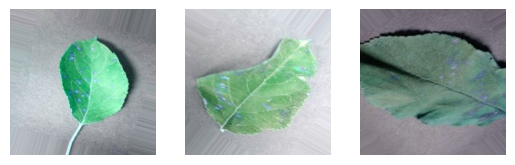

In [23]:
aug_img1 = cv2.imread('dataset/color/Apple___Cedar_apple_rust/augment_127.jpg', cv2.IMREAD_COLOR)
aug_img2 = cv2.imread('dataset/color//Apple___Cedar_apple_rust/augment_151.jpg', cv2.IMREAD_COLOR)
aug_img3 = cv2.imread('dataset/color//Apple___Cedar_apple_rust/augment_164.jpg', cv2.IMREAD_COLOR)

# Plotting 3 augmented images
fig, axs = plt.subplots(1, 3)
axs[0].imshow(aug_img1)
axs[0].axis('off')
axs[1].imshow(aug_img2)
axs[1].axis('off')
axs[2].imshow(aug_img3)
axs[2].axis('off');

